/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:101: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.


[epoch 1, iter    80] loss: 438.249 eplased time 0.147
[epoch 2, iter    80] loss: 430.787 eplased time 0.172
[epoch 3, iter    80] loss: 429.896 eplased time 0.160
[epoch 4, iter    80] loss: 427.054 eplased time 0.163
[epoch 5, iter    80] loss: 421.190 eplased time 0.181
[epoch 6, iter    80] loss: 415.359 eplased time 0.151
[epoch 7, iter    80] loss: 413.684 eplased time 0.141
[epoch 8, iter    80] loss: 410.773 eplased time 0.135
[epoch 9, iter    80] loss: 409.682 eplased time 0.158
[epoch 10, iter    80] loss: 404.644 eplased time 0.147
[epoch 11, iter    80] loss: 401.223 eplased time 0.170
[epoch 12, iter    80] loss: 398.845 eplased time 0.175
[epoch 13, iter    80] loss: 393.035 eplased time 0.148
[epoch 14, iter    80] loss: 390.525 eplased time 0.133
[epoch 15, iter    80] loss: 387.281 eplased time 0.166
[epoch 16, iter    80] loss: 384.752 eplased time 0.161
[epoch 17, iter    80] loss: 383.243 eplased time 0.139
[epoch 18, iter    80] loss: 376.626 eplased time 0.155
[

[epoch 147, iter    80] loss: 159.146 eplased time 0.182
[epoch 148, iter    80] loss: 158.801 eplased time 0.173
[epoch 149, iter    80] loss: 158.357 eplased time 0.192
[epoch 150, iter    80] loss: 157.123 eplased time 0.185
[epoch 151, iter    80] loss: 157.272 eplased time 0.182
[epoch 152, iter    80] loss: 158.049 eplased time 0.176
[epoch 153, iter    80] loss: 155.125 eplased time 0.191
[epoch 154, iter    80] loss: 157.931 eplased time 0.192
[epoch 155, iter    80] loss: 156.437 eplased time 0.199
[epoch 156, iter    80] loss: 157.560 eplased time 0.180
[epoch 157, iter    80] loss: 156.868 eplased time 0.185
[epoch 158, iter    80] loss: 156.806 eplased time 0.184
[epoch 159, iter    80] loss: 156.716 eplased time 0.208
[epoch 160, iter    80] loss: 155.963 eplased time 0.197
[epoch 161, iter    80] loss: 155.009 eplased time 0.175
[epoch 162, iter    80] loss: 155.710 eplased time 0.200
[epoch 163, iter    80] loss: 155.176 eplased time 0.176
[epoch 164, iter    80] loss: 1

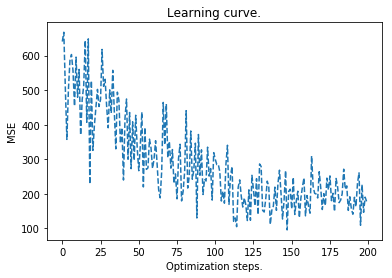

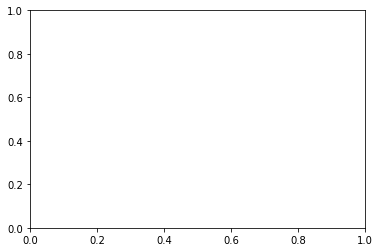

In [7]:
import numpy as np
import torch
import torch.utils.data as data_utils
from torch import nn, optim
from torch.autograd import Variable
from torch.nn import functional as F
from torchvision import datasets, transforms
import math
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
import time

#Takes in csv file and loads it so that it is a pytorch tensor for training and testing data
def loader():
	X_train, y_train, X_test, y_test = None, None, None, None

	#Read csv file and drop unncecessary columns
	data = pd.read_csv('combined_data.csv')
	data = data.drop(data.columns[0], axis=1)
	data = data.drop(['LAST','FIRST','ID','MIDDLE','APPT FTR BASIS','APPT FRACTION','AMT OF SALARY PAID FROM GENL FUND',
		'FOS', 'Middle', 'url', 'X1', 'found'], axis=1)
	data = data.drop(data.columns[17], axis=1)

	#Get number of unique values
	columns = list(data.columns.values)
	unique_vals_set = set()
	for i in columns:
		unique_vals_set.update(set(data[i].unique().tolist()))
	unique_vals = len(unique_vals_set)

	unique_vals_list = list(unique_vals_set)

	index = 1
	dictionary = {'NaN':0}
	for index, val in enumerate(unique_vals_list):
		if val not in dictionary:
			dictionary[unique_vals_list[index]] = index
			index += 1

	data = data.replace(dictionary)

	#Turn data to numpy array
	data = data.values

	#Full dataset variables of X and Y
	y_vals = data[:, 16]
	X_vals = data[:,:16]
	indices = np.random.permutation(y_vals.shape[0])
	training_idx, test_idx = indices[:math.floor(y_vals.shape[0] * 0.9)], indices[math.floor(y_vals.shape[0] * 0.9):]
	
	X_train = X_vals[training_idx, :]
	X_test = X_vals[test_idx,:]
	y_train = y_vals[training_idx]
	y_test = y_vals[test_idx]



	return X_train, y_train, X_test, y_test, unique_vals


#Our Model's class
class NeuralNet(nn.Module):
	def __init__(self, embed_units, hidden_units1=50, hidden_units2=100, output_units=1, inp_units=20):
		super().__init__()

		#Change these to our liking. Maybe add Batchnorm or L2 Normalization?
		#Also maybe do weight initialization ourselves?

		self.embed = nn.Embedding(embed_units, 18) #Figure out how we want to do embedding
		self.fc = nn.Sequential(
			# N x ? tensor (? WILL BE KNOWN ONCE EMBEDDING HAS BEEN IMPLEMENTED)
			nn.Linear(18, hidden_units1),
			nn.ReLU(inplace=True),
			nn.Dropout(0.2),
			# N x 100 tensor
			nn.Linear(hidden_units1, hidden_units2),
			nn.ReLU(inplace=True),
			nn.Dropout(0.1),
			# N x 200 tensor
			nn.Linear(hidden_units2, hidden_units1),
			nn.Tanh(),
			# N x 100 tensor
			nn.Linear(hidden_units1,output_units),
			nn.ReLU(inplace=True)
			# N x 1 tensor
			)


	def forward(self, x):
		# x is an N x dim tensor
		y_hat = self.embed(x.long()) #Add the embedding once figured out
		y_hat = self.fc(y_hat) 
		return y_hat

#Set weights of model
def init_weights(m):
	if type(m) == nn.Linear:
		torch.nn.init.xavier_uniform(m.weight)
		m.bias.data.fill_(0.01)

def NeuralTrain(trainloader, net, criterion, optimizer, device):
	loss_graph = []
	for epoch in range(200):  # loop over the dataset for x number of epochs
		start = time.time()
		running_loss = 0.0

		#For each batch run through model, backprop, and optimize weights
		for i, (data, salary) in enumerate(trainloader):
			data = data.to(device).float()
			salary = salary.to(device).float()

			optimizer.zero_grad()
			output = net(data)
			loss = criterion(output, salary)
			loss.backward()
			optimizer.step()

			# print statistics
			running_loss += loss.item()
			
			if i % 80 == 79:
				loss_graph.append(loss.item())
				end = time.time()
				print('[epoch %d, iter %5d] loss: %.3f eplased time %.3f' % 
					(epoch + 1, i + 1, running_loss / 100, end - start))
				start = time.time()
				running_loss = 0.0
    
	# Plot learning curve
	fig1, ax1 = plt.subplots()
	ax1.plot(loss_graph, '--')
	ax1.set_title('Learning curve.')
	ax1.set_ylabel('MSE')
	ax1.set_xlabel('Optimization steps.')

	print('Finished Training')

def NeuralTest(testloader, net, criterion, device):
	total = 0
	error = []
	fig2, ax2 = plt.subplots()
	with torch.no_grad():
		for data in testloader:
			representations, salary = data
			representations = representations.to(device).float()
			salary = salary.to(device).float()
			outputs = net(representations)
			loss = criterion(outputs, salary)
			'''
			ax2.plot(outputs.numpy(), salary.numpy(), 'r+')
			ax2.set_title('Prediction Plot')
			ax2.set_ylabel('Actual Salary')
			ax2.set_xlabel('Prediction')
			'''
			error.append(loss)
	print('Error: %d dollars' % (np.mean(error)))

def main():
	#Sets device to cpu or gpu if you have one
	device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

	#Get our datasets loaded
	X_train, y_train, X_test, y_test, unique_vals = loader()

	#Turn numpy matrices into pytorch tensors for neural network
	#Turn numpy matrices into pytorch tensors for neural network
	X_train = torch.tensor(X_train.astype(dtype = 'float32'))
	y_train = torch.tensor(y_train.astype(dtype = 'float32'))
	X_test = torch.tensor(X_test.astype(dtype = 'float32'))
	y_test = torch.tensor(y_test.astype(dtype = 'float32'))

	#Put them into torch datasets with batch size 
	#BATCH SIZE CAN CHANGE TO WHATEVER WORKS BEST
	trainset = data_utils.TensorDataset(X_train, y_train)
	trainloader = torch.utils.data.DataLoader(trainset, batch_size=5, shuffle=True)

	testset = data_utils.TensorDataset(X_test, y_test)
	testloader = torch.utils.data.DataLoader(testset, batch_size=y_test.shape[0], shuffle=False)

	#Model and Loss
	net = NeuralNet(embed_units=unique_vals).to(device)
	net.apply(init_weights)
	criterion = nn.L1Loss()

	#Can also switch from adam to sgd if we so choose
	optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

	#Train and Test model
	NeuralTrain(trainloader, net, criterion, optimizer, device)
	NeuralTest(testloader, net, criterion, device)



if __name__ == '__main__':
	main()


























